In [1]:
# import necessary libraries

# loading and reading data
import numpy as np
import pandas as pd

# libraries for visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Library for splitting data
from sklearn.model_selection import train_test_split

from pycaret.classification import *



# library for scaling
from sklearn.preprocessing import StandardScaler

# library to encode categorical data
from sklearn.preprocessing import LabelEncoder

#Library for traditional models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier
#from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

#library for deep neural network models
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
#from keras.models import Sequential
#from keras.layers import Dense, Conv1D, Dropout
import tensorflow as tf
#from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten
#from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# library for hyper-parameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from scipy.stats import randint, uniform

# library for data augmentation
from imblearn.over_sampling import SMOTE

# library for result evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc , roc_curve, roc_auc_score
from sklearn.metrics import classification_report,ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import FunctionTransformer

# Others
from sklearn.preprocessing import label_binarize
import time
import warnings

In [2]:
# load the data set(maternal_health data)

df = pd.read_csv('Maternal Health Risk Data Set.csv')


In [3]:
# Check the first 5 columns of the data set
df.head(5)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


### Data Features explanation
|Feature	|Description	                                                                    |Unit      |
|-----------|-----------------------------------------------------------------------------------|----------|
|Age	    |Ages in years when a woman is pregnant	                                            |          |
|SystolicBP	|Upper value of Blood Pressure                                                      |mmHg      |
|DiastolicBP|Lower value of Blood Pressure	                                                    |mmHg      |
|BS	        |Blood glucose levels is in terms of a molar concentration	                        |mmol/L    |
|BodyTerm	|Bodytemperature	                                                                |Fahrenheit|
|HeartRate	|A normal resting heart rate	                                                    |bpm       |
|RiskLevel	|Predicted Risk Intensity Level during pregnancy considering the previous attribute |          |	


## 1. Data Overview

- Data Stucture
- Data Quality check
- Data Descriptive analysis

### 1.1 Data Structure

| Task           | Objective                                             |
|----------------|-------------------------------------------------------|
| Data Dimension | To know the number of columns and rows of the dataset |
| Data Types     | To verify that the data types align with the features |
| Data Columns   | To list and understand the columns                    |


### 1.1.0 Data Structure code line

In [4]:
# checking the dimensionality of the data set
print(f" Data set Dimensions: {df.shape}")

print('---------------------------------------')
# Checking the data types
print(f" Data types:\n{df.dtypes}")

print('----------------------------------------')
# check the data columns
print(f" Data columns: {df.columns}")


 Data set Dimensions: (1014, 7)
---------------------------------------
 Data types:
Age              int64
SystolicBP       int64
DiastolicBP      int64
BS             float64
BodyTemp       float64
HeartRate        int64
RiskLevel       object
dtype: object
----------------------------------------
 Data columns: Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel'],
      dtype='object')


### 1.2 Data Quality Check

| Task        |Objective                                              |
|-------------|-------------------------------------------------------|
|missing value| identify missing data and understand its extent       |
|Data Range   | verify numerical data is within expected bounds       |

### 1.2.1 Code for Data Quality Check

In [5]:
# check for missing value
print(f"missing value: {df.isnull().sum()}")

print('----------------------------------------')
# check for data range and validity
num_columns = df.select_dtypes(include=['number']).columns
for col in num_columns:
    print(f"{col}: min = {df[col].min()}, max = {df[col].max()}")




missing value: Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64
----------------------------------------
Age: min = 10, max = 70
SystolicBP: min = 70, max = 160
DiastolicBP: min = 49, max = 100
BS: min = 6.0, max = 19.0
BodyTemp: min = 98.0, max = 103.0
HeartRate: min = 7, max = 90


***Observations of the data range check***
The minimum heart rate is 7 and the maximum is 70. It is biologically impossible to have a heart rate of 7. According to the guiness world record, the lowest heartrate ever recorded is 27bmp. This will be considered as data inputation error. We will investigate and find the number of rows with this anomaly and treat accordingly

In [6]:
# check the number of rows with the heart rate anomaly
hrt_anomaly = df[(df['HeartRate'] >= 7) & (df['HeartRate'] <= 26)].shape[0]

print(f"Number of entries with heartrate between 7 and 26: {hrt_anomaly}")

Number of entries with heartrate between 7 and 26: 2


In [7]:
# Check for the mode of the HeartRtae column
hrt_mode = df['HeartRate'].mode()[0]

print(f"The mode of the Heart Rate : {hrt_mode}")

The mode of the Heart Rate : 70


In [8]:
# Replace the Heart Rate anomaly with the mode

df['HeartRate'] = df['HeartRate'].replace(7, hrt_mode)



In [9]:
# Calculate Mean Arterial Pressure (MAP)
df['MAP'] = df['DiastolicBP'] + (1/3) * (df['SystolicBP'] - df['DiastolicBP'])

In [10]:
# Calculate Pulse Pressure
df['PulsePressure'] = df['SystolicBP'] - df['DiastolicBP']

### 1.3 Data descriptive analysis

| Task                             | Objective                                                                          |
|----------------------------------|------------------------------------------------------------------------------------|
|statistics of numerical features  | quick overview of the distribution and central tendencies of the numerical features|
|statistics of categorical features| understand class distribution of categorical variable                              |

### 1.3.1 Code for Data Statistics distribution

In [11]:
# check the summary statistics of numerical features
print('The summary Statistics of numerical features:')
df.describe().T

The summary Statistics of numerical features:


,count,mean,std,min,25%,50%,75%,max
Age,1014.0,29.871795,13.474386,10.000000,19.000000,26.000000,39.0,70.0
SystolicBP,1014.0,113.198225,18.403913,70.000000,100.000000,120.000000,120.0,160.0
DiastolicBP,1014.0,76.460552,13.885796,49.000000,65.000000,80.000000,90.0,100.0
BS,1014.0,8.725986,3.293532,6.000000,6.900000,7.500000,8.0,19.0
BodyTemp,1014.0,98.665089,1.371384,98.000000,98.000000,98.000000,98.0,103.0
HeartRate,1014.0,74.426036,7.517006,60.000000,70.000000,76.000000,80.0,90.0
MAP,1014.0,88.706443,14.584820,56.666667,76.666667,93.333333,100.0,120.0
PulsePressure,1014.0,36.737673,11.369944,8.000000,30.000000,35.000000,40.0,75.0


In [12]:
# check the summary statistics of the class distribution of the target variable
print(df.describe(include='object'))

# Value counts for categorical features
print("\nCategorical Data Insights:")
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col} frequency:")
    print(df[col].value_counts())



       RiskLevel
count       1014
unique         3
top     low risk
freq         406

Categorical Data Insights:
RiskLevel frequency:
RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64


### 1.3.1 Further analysis on the numerical features

In [13]:
# Skewness and Kurtosis
print("\nSkewness and Kurtosis:")
for col in df.select_dtypes(include=['number']).columns:
    skewness_value = round(df[col].skew(),2)
    kurtosis_value = round(df[col].kurt(),2)
    print(f"{col}: Skewness = {skewness_value}, Kurtosis = {kurtosis_value}")


Skewness and Kurtosis:
Age: Skewness = 0.78, Kurtosis = -0.39
SystolicBP: Skewness = -0.25, Kurtosis = -0.61
DiastolicBP: Skewness = -0.05, Kurtosis = -0.95
BS: Skewness = 1.87, Kurtosis = 2.3
BodyTemp: Skewness = 1.75, Kurtosis = 1.45
HeartRate: Skewness = 0.07, Kurtosis = -0.48
MAP: Skewness = -0.16, Kurtosis = -0.75
PulsePressure: Skewness = 0.47, Kurtosis = 0.07


***Observation on Skewness***
 1) Age and PulsePressure are moderately skewed.
 2) BS and BodyTemp: positvely skewed, suggesting the presence of higher values pulling the tail of the distribution to the right
 
***Observation on Kurtosis***
 1) BS, BodyTemp: High positve kurtosis which indicates some extreme values or presence of outliers
 2) Age, SystolicBP, DiastolicBP, HeartRate,MAp, PulsePressure: Negative kurtosis which suggests a flatter distribution with minimum outliers

## 3. Exploratory Data Analysis(EDA)
- **EDA** is a vital step in the data analysis process and it involves summarizing a dataset's main characteristics using visuals.
it's importance includes:
1) understand the data structure
2) detect patterns and anomalies
3) formuate hypothesis for further analysis

### 3.1. Univariate analysis on the target variable distribution
- **Bar plot:** to visualize the count of each class
- **Pie chart:** to visualize the percentage distribution of each class

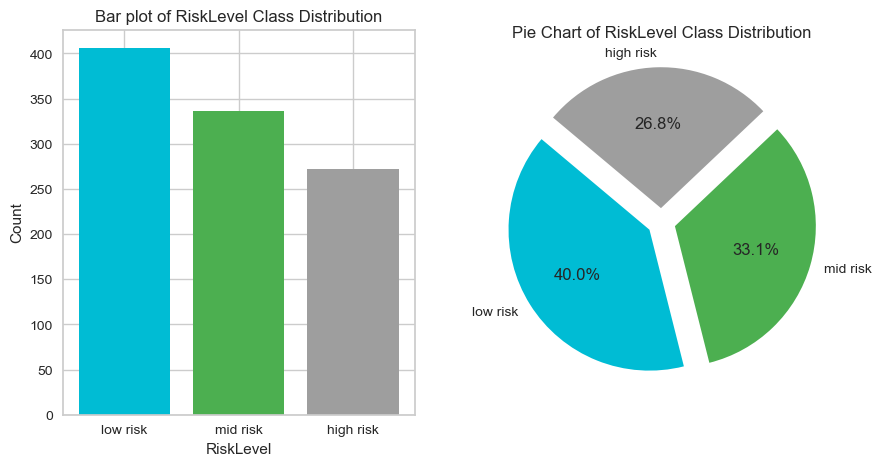

In [14]:
# Calculate the class distribution
class_dis = df['RiskLevel'].value_counts()

#create color tones
colors = ['#00bcd4', '#4caf50', '#9e9e9e']


# create subplots for bar plot and pie chart
fig, ax = plt.subplots(1,2, figsize=(10,5))

# Bar Chart
ax[0].bar(class_dis.index, class_dis.values, color=colors)#['gray', 'darkorange', 'cornflowerblue'])
ax[0].set_title('Bar plot of RiskLevel Class Distribution')
ax[0].set_xlabel('RiskLevel')
ax[0].set_ylabel('Count')


# Pie Chart
ax[1].pie(class_dis.values, labels=class_dis.index, autopct='%1.1f%%', startangle=140, explode=(0.1, 0.1, 0.1),
          colors=colors)#['gray', 'darkorange', 'cornflowerblue'])
ax[1].set_title('Pie Chart of RiskLevel Class Distribution')

# To display plot
plt.show();

***Observation on the RiskLevel Plot***

- The above plots suggest our target variable RiskLevel has low risk of 40%, mid risk of 33.1% and high risk of 26.8%.
This clearly indicates a somwwhat class inbalance among our target variable.

### 3.3. Correlation heat map of the features
- The heatmap is used to visualize the relationship between numerical features in the dataset
- **+1.0:** indicate perfect positive relation. positive values means as one feature increases, the other tends to increase too
- **-1.0:** indicate perfect negative relation. negative values means as one feature increases, the other decrease
- **0.0:** means no relation. suggesting the features has no linear relationship(no dependence)

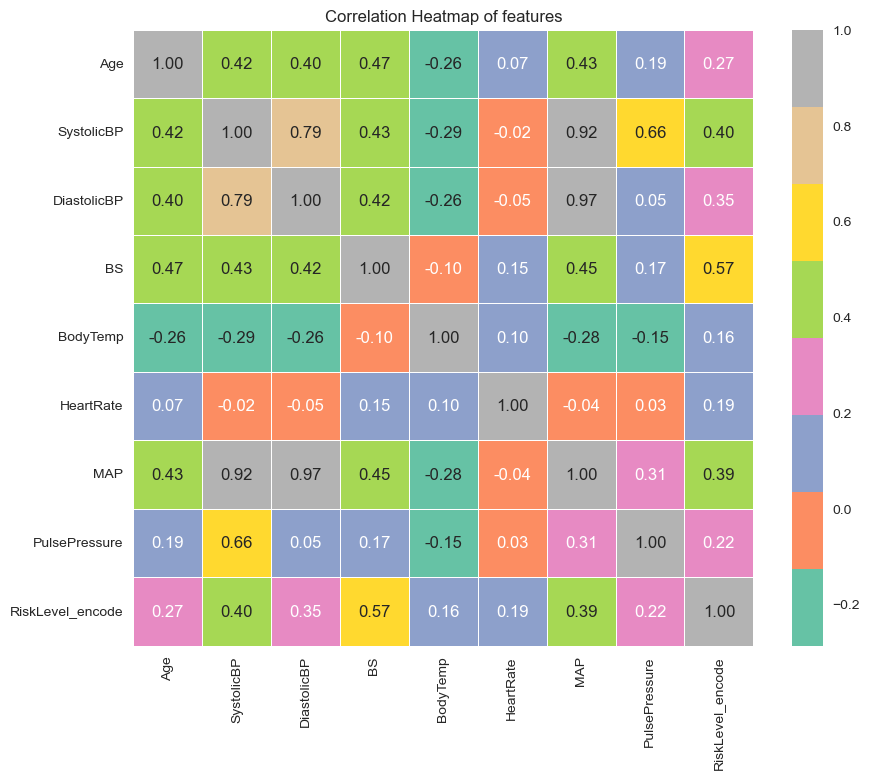

In [15]:
# Mapping risk levels to numeric values
risk_map = {'low risk': 0, 'mid risk': 1, 'high risk': 2}
df['RiskLevel_encode'] = df['RiskLevel'].map(risk_map)

# Calculate the correlation matrix
corr_features = df.drop('RiskLevel', axis=1)
corr_matrix = corr_features.corr()

# set the colors for the heatmap
#custom_palette = sns.diverging_palette(30, 200, s=100, l=50, n=400, center="light")

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap= 'Set2', cbar=True, linewidths=0.5)
plt.title('Correlation Heatmap of features')
plt.show();



***Corelation heatmap key observations***

- All features have a positive correlation with the target variable **RiskLevel**

- **features with strong positve correlations:**
    - **SystolicBP and DiastolicBP**  
     
- **features with moderate positive correlations:**
    - **Age with SystolicBP, DiastolicBP and BS (0.47)**

- **Low correlation:**
    - **BodyTemp and HeartRate:** shows very low or no correlation with other features, suggesting independence on other features.

### 3.2. 3D of some correlated features

***Plot 1***

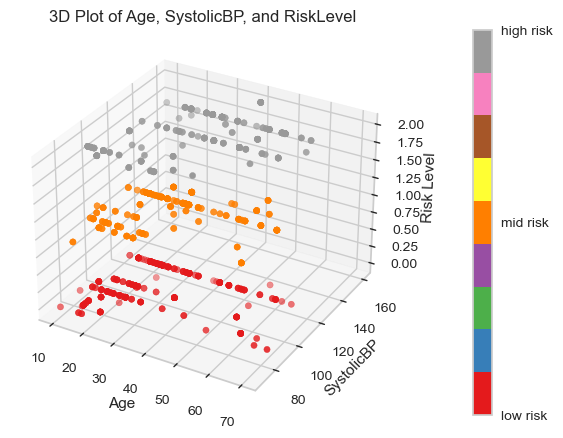

In [16]:
# Selecting features for the plot
feat1 = 'Age'
feat2 = 'SystolicBP'

# Creating the 3D plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

# Plotting the data
sc = ax.scatter(df[feat1], df[feat2], df['RiskLevel_encode'], c=df['RiskLevel_encode'], cmap='Set1', marker='o')

# Adding labels and title
ax.set_xlabel(feat1)
ax.set_ylabel(feat2)
ax.set_zlabel('Risk Level')
ax.set_title('3D Plot of Age, SystolicBP, and RiskLevel')

# Adding a color bar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['low risk', 'mid risk', 'high risk'])

plt.show()


***Plot 2***


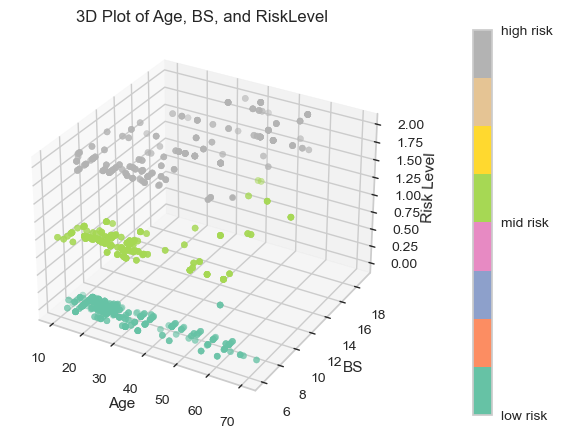

In [17]:
# additional 3D plot
feat3 = 'BS'
# Creating the 3D plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

# Plotting the data
sc = ax.scatter(df[feat1], df[feat3], df['RiskLevel_encode'], c=df['RiskLevel_encode'], cmap='Set2', marker='o')

# Adding labels and title
ax.set_xlabel(feat1)
ax.set_ylabel(feat3)
ax.set_zlabel('Risk Level')
ax.set_title('3D Plot of Age, BS, and RiskLevel')

# Adding a color bar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['low risk', 'mid risk', 'high risk'])

plt.show()



***Observations from plots***

Plot 1 and plot 2 shows that risk levels are spread across different ages both younger and older. It further shows that age alone is not a determinate of risk in pregnancy. Instead, the risk level seems to be influenced by a combination of age and other factors such as blood sugar and Blood pressure.
- **High Risk**: Predominantly among higher systolicBP values and also higher Blood sugar thou present across the range of ages.
- **Mid and Low Risk**: shows the same pattern with high risk. Predominant among Lower systolicBP and Blood sugar



### 3.3. Visualizing skewness using Histogram

- **Skewness** measures how evenly spread the bell curve  on data points is on both sides of the median. if the spread is tilted more to the left than the right, it is said to be negatively skew and positively skewed if tilted more to the right than to the left. The data points is said to be zero symmetric if the bell shape have an even distribution on both sides

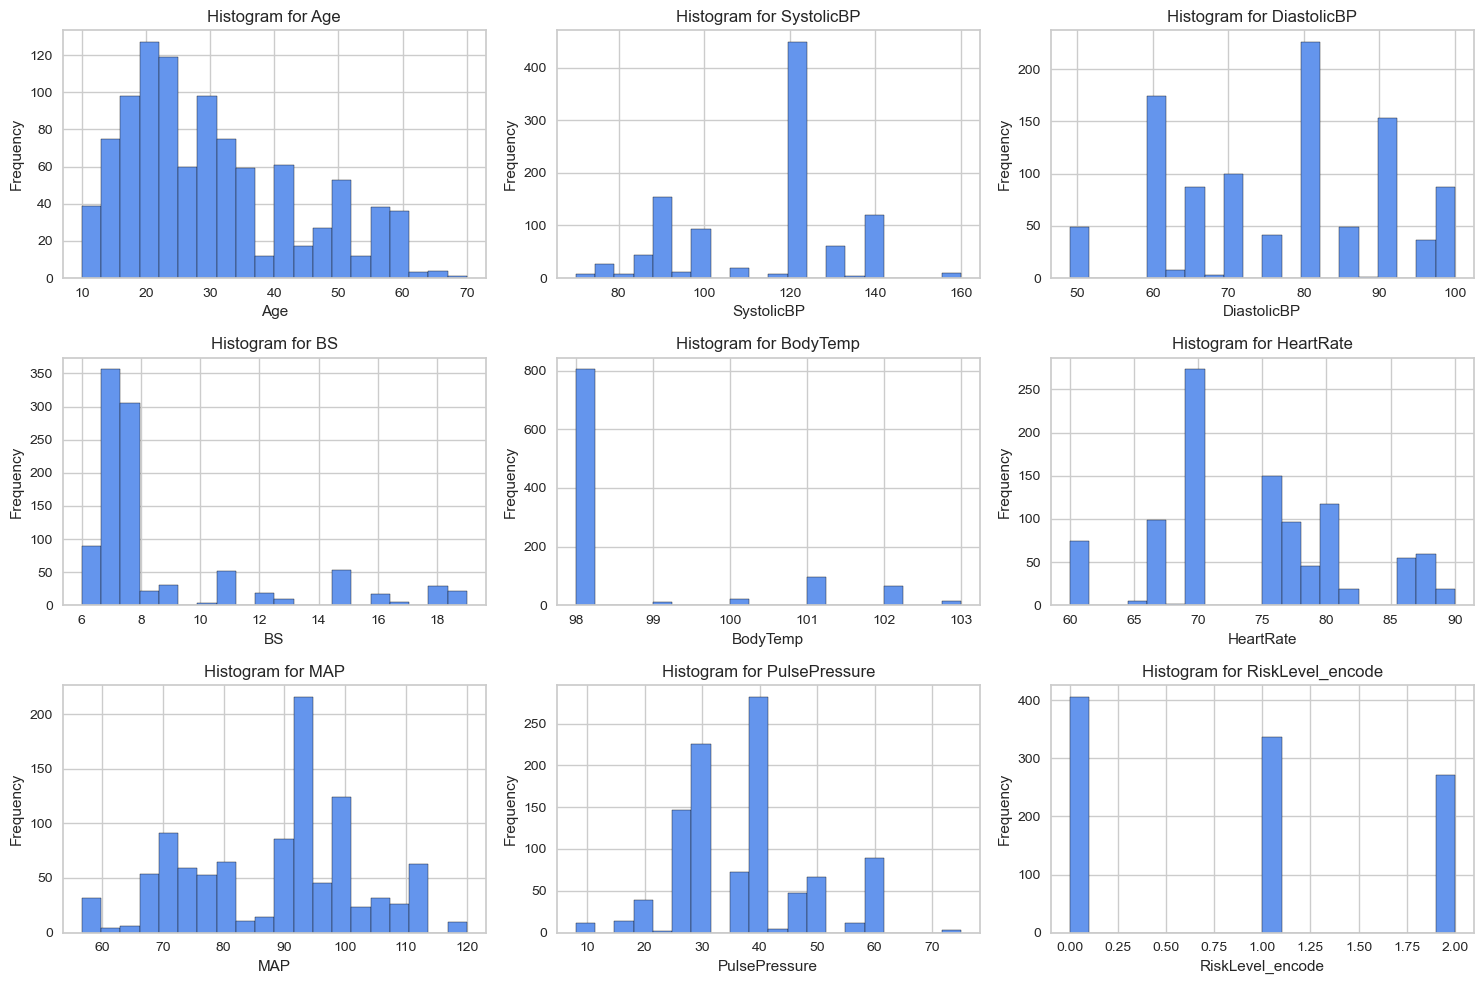

In [18]:
# Visualize skewness using histogram for each numerical feature

num_cols = df.select_dtypes(include='number').columns

plt.figure(figsize=(15, 10))
for i, column in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    plt.hist(df[column].dropna(), bins=20, edgecolor='k', color='cornflowerblue')
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


***Histogram Observation***


- From the above it is seen that BS and Body Temp are highly skewed. BS and Body Temp are positively skewed.Age is moderately skewed. Diastolic, systolic, and HeartRate are approximately symmetric

### 3.5. Box plot for visualizing presence of outliers

- The presence of outliers in a dataset can significantly impact model performance as extreme values or very low values can affect our model ability to classify instances and potentially leading to poor generalization and bias.

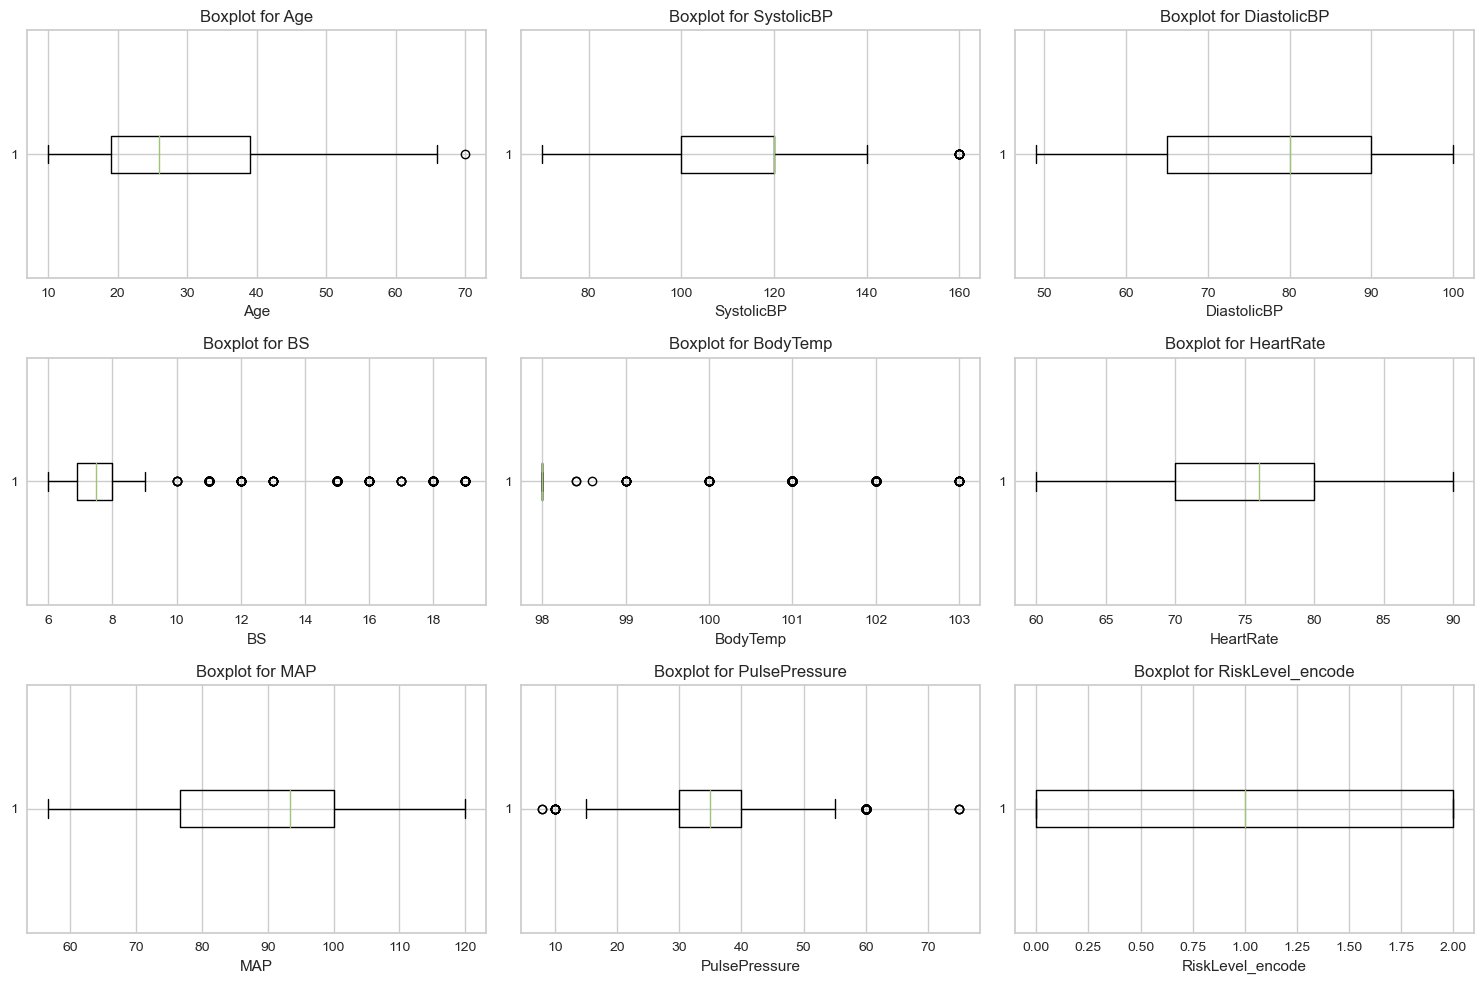

In [19]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    plt.boxplot(df[column].dropna(), vert=False)
    plt.title(f'Boxplot for {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

***Box plot observation***

- BS and BodyTemp have the highest number of outliers, indicating that they contain values that are either extremely high or extremely low compared to the concentration of other data points.

In order to overcome this, we will employ z-score standardization so as to make the distribution close to normal

### 3.4. Pairplot of some correlated features

<Figure size 1000x500 with 0 Axes>

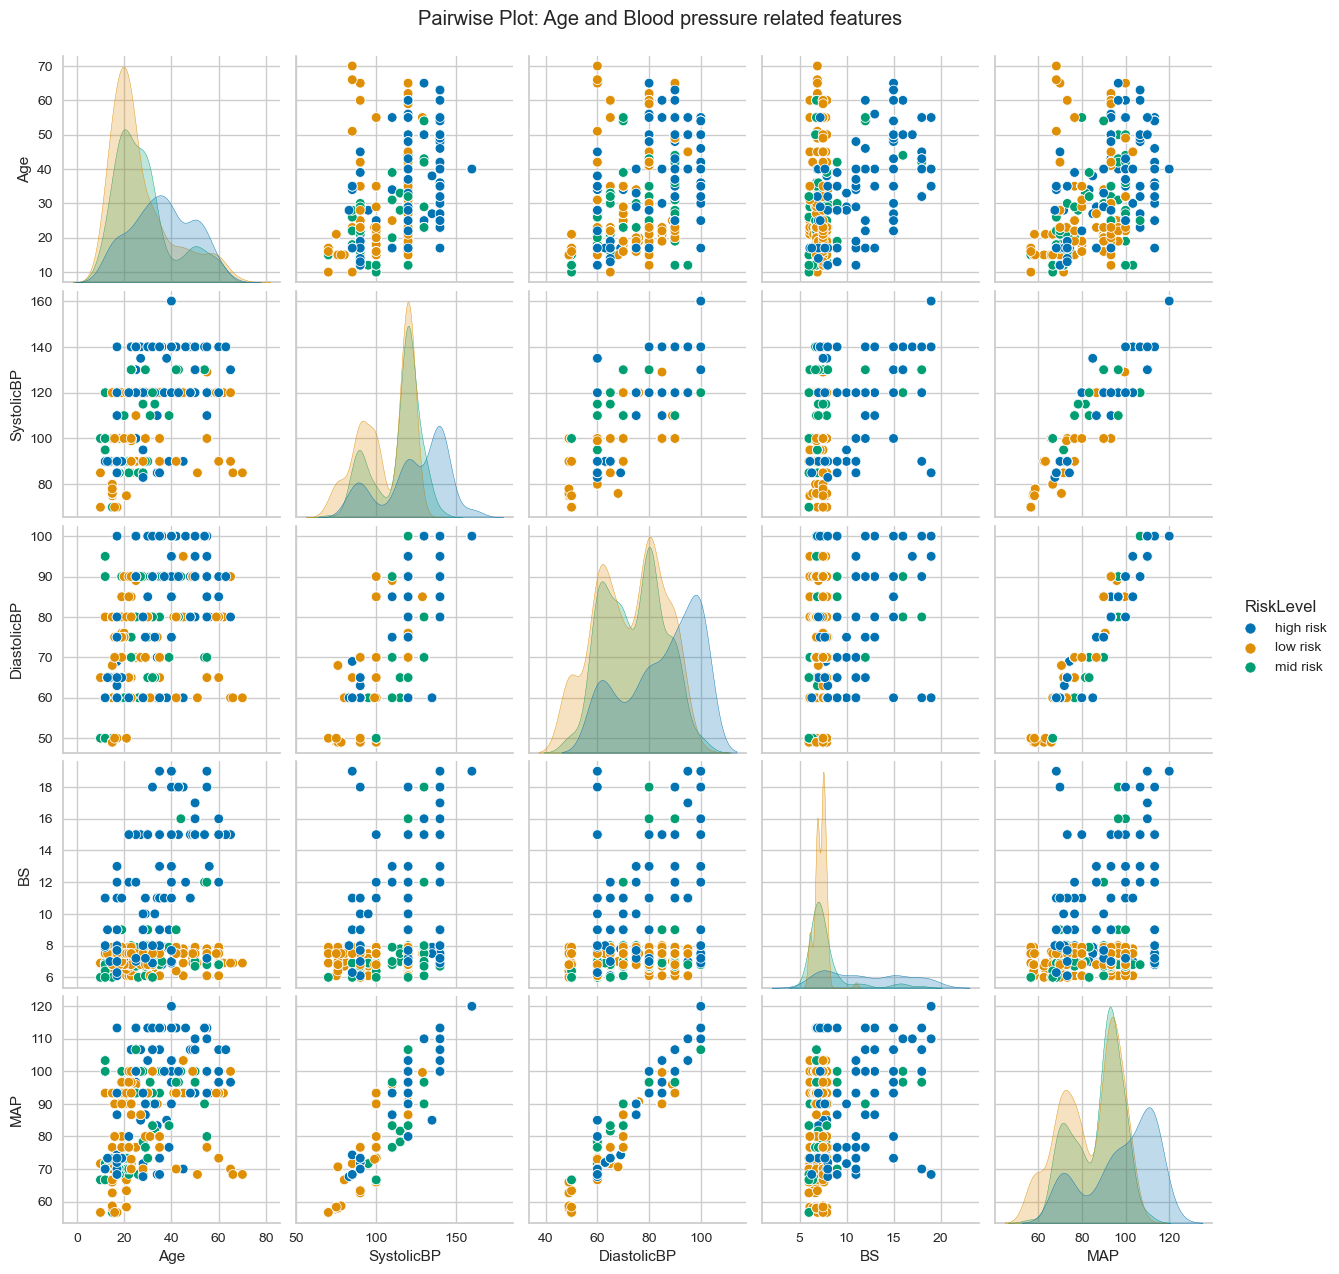

In [20]:
# Define feature sets
features_1 = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'MAP']

# Pairwise plot 
plt.figure(figsize=(10, 5))
sns.pairplot(df, vars=features_1, hue='RiskLevel', palette='colorblind')
plt.suptitle('Pairwise Plot: Age and Blood pressure related features', y=1.02)
plt.show();


***Pair Plot Observation***
- There is a linear relationship between diastolicBP and systolicBP. This shows that as one increase, the other increases too.
- Age has no linear relationship with other features. Suggesting that risk in preganacy is not solely dependent on age but likely influenced by other factors
- The higher the Blood sugar, the more likelihood of a high risk pregnancy

## 4. Data Preprocessing
- It is essential to preprocess the data so as to ensure that the data is clean, well-formatted, and ready for model training.
This process when carefully done leads to more accurate and reliable results.

- **The following preprocessing will be applied:**
    - **identify and handle anomalies if any**
    - **Segment Data**
    - **Encode Categorical features where applicable**
    - **Scale and standardize features**
    - **Split data**
    

### 4.1. Identify and handle anomalies(where applicable)
- it has been established that our data does not contain any missing values. 

### 4.2. Segment Data
- **The target variable(Y) will be separated from the independent variables(X)**
- The target variable is the output our model will aim to predict.
- The independent variables will be the input our model will use to learn patterns and make predictions.

In [21]:
X = df.drop(['RiskLevel','RiskLevel_encode'],axis=1)
y = df['RiskLevel_encode']

### 4.3. Encode Categorical features
It is essential for us to transform our categorical data to numerical for easy interpretabilty by our model as most model require numerical input. This ensures that the model can process the data effectively, leading to improved performance and accuracy.Following the mapping of our target variable, we will not perform any new encoding on my target variable

### 4.4. Split Data
- **Train and Test:** Our data will be split into training and testing sets, The training will be used training the model. The test set will be used to evaluate our model's performance on unseen data(test set).
- **Random state:** The random state will be set to a fixed interger. This ensures reproductivity meaning that for every time the code is ran, the split between the training and testing remains the same.
- **Stratification:** stratifying the target variable(y) ensures that the class distribution of the test and train will closely match that of the original data class distribution

In [22]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify=y)

### 4.5. Scale and Standardize the independent features(X)
it is important to scale/standardize our data before feeding it to a model as this helps to ensure that all features contribute equally to the model performance and prevents features with larger values to dominate the model learning process. 

In [23]:
# instantiate our scaling method
scaler = StandardScaler()

# feed the independent variables(X) to our scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Model building
We will utilize pycaret,  scikit-learn libraries and tensor flow in building our model. 
- **Pycaret** will be used in selecting traditional models to use.
- **Scikit-learn** will be used in building the selectd model
- **Tensor flow** we will use it to build a fastforward neural network model
The scope of our model is to extract predictions of our ensemble model(traditional+neural network) and train a meta model on the extracted predictions to get a final predictions.

In [24]:
# selection of our traditional model

models = [[RandomForestClassifier(random_state=123), 'Random Forest'],
               [GradientBoostingClassifier(random_state=123), 'Gradient Boost'],
               [XGBClassifier(random_state=123), 'XGB Classifier'],
               [ExtraTreesClassifier(random_state=123), 'ET Classifier'],
               [CatBoostClassifier(random_state=123), 'CB Classifier']]

In [25]:
metrics = {'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'ROC AUC Score': []
}

In [26]:
# Run the training loop
for model, model_name in models:
    #fit the model
    model.fit(X_train_scaled, y_train)
   
    #evaluate the model
    pred = model.predict(X_test_scaled)
    
    acc_score = accuracy_score(y_test, pred)
    pre_score = precision_score(y_test, pred, average='macro')
    recal_score = recall_score(y_test, pred, average='macro')
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test_scaled), multi_class='ovr')
    
    # Store metrics
    metrics['Model'].append(model_name)
    metrics['Accuracy'].append(f"{round(acc_score * 100, 2)}%")
    metrics['Precision'].append(f"{round(pre_score * 100, 2)}%")
    metrics['Recall'].append(f"{round(recal_score * 100, 2)}%")
    metrics['ROC AUC Score'].append(f"{round(roc_score * 100, 2)}%")
    
    if model_name != models[-1][1]:
        print(f"Evaluated {model_name}")

Evaluated Random Forest
Evaluated Gradient Boost
Evaluated XGB Classifier
Evaluated ET Classifier
Learning rate set to 0.078286
0:	learn: 1.0572686	total: 137ms	remaining: 2m 16s
1:	learn: 1.0189159	total: 141ms	remaining: 1m 10s
2:	learn: 0.9853115	total: 144ms	remaining: 47.9s
3:	learn: 0.9544934	total: 147ms	remaining: 36.5s
4:	learn: 0.9224664	total: 149ms	remaining: 29.6s
5:	learn: 0.8984902	total: 151ms	remaining: 25s
6:	learn: 0.8736486	total: 152ms	remaining: 21.6s
7:	learn: 0.8533030	total: 154ms	remaining: 19.1s
8:	learn: 0.8346205	total: 155ms	remaining: 17.1s
9:	learn: 0.8136561	total: 157ms	remaining: 15.5s
10:	learn: 0.8005145	total: 158ms	remaining: 14.2s
11:	learn: 0.7850940	total: 160ms	remaining: 13.2s
12:	learn: 0.7709584	total: 161ms	remaining: 12.2s
13:	learn: 0.7571055	total: 163ms	remaining: 11.5s
14:	learn: 0.7475849	total: 164ms	remaining: 10.8s
15:	learn: 0.7360341	total: 166ms	remaining: 10.2s
16:	learn: 0.7255325	total: 167ms	remaining: 9.65s
17:	learn: 0.71

277:	learn: 0.3100934	total: 564ms	remaining: 1.46s
278:	learn: 0.3093288	total: 566ms	remaining: 1.46s
279:	learn: 0.3090915	total: 568ms	remaining: 1.46s
280:	learn: 0.3086122	total: 569ms	remaining: 1.46s
281:	learn: 0.3077249	total: 571ms	remaining: 1.45s
282:	learn: 0.3071818	total: 572ms	remaining: 1.45s
283:	learn: 0.3068449	total: 574ms	remaining: 1.45s
284:	learn: 0.3062656	total: 575ms	remaining: 1.44s
285:	learn: 0.3057487	total: 576ms	remaining: 1.44s
286:	learn: 0.3053520	total: 578ms	remaining: 1.44s
287:	learn: 0.3050983	total: 580ms	remaining: 1.43s
288:	learn: 0.3044929	total: 582ms	remaining: 1.43s
289:	learn: 0.3039857	total: 583ms	remaining: 1.43s
290:	learn: 0.3035373	total: 585ms	remaining: 1.42s
291:	learn: 0.3029785	total: 586ms	remaining: 1.42s
292:	learn: 0.3026484	total: 587ms	remaining: 1.42s
293:	learn: 0.3023885	total: 589ms	remaining: 1.41s
294:	learn: 0.3020295	total: 590ms	remaining: 1.41s
295:	learn: 0.3012200	total: 592ms	remaining: 1.41s
296:	learn: 

536:	learn: 0.2390038	total: 959ms	remaining: 827ms
537:	learn: 0.2388937	total: 961ms	remaining: 825ms
538:	learn: 0.2388049	total: 962ms	remaining: 823ms
539:	learn: 0.2386309	total: 964ms	remaining: 821ms
540:	learn: 0.2383829	total: 965ms	remaining: 819ms
541:	learn: 0.2382200	total: 967ms	remaining: 817ms
542:	learn: 0.2380999	total: 968ms	remaining: 815ms
543:	learn: 0.2379518	total: 970ms	remaining: 813ms
544:	learn: 0.2378413	total: 971ms	remaining: 811ms
545:	learn: 0.2376958	total: 973ms	remaining: 809ms
546:	learn: 0.2375404	total: 975ms	remaining: 808ms
547:	learn: 0.2373689	total: 977ms	remaining: 806ms
548:	learn: 0.2372886	total: 978ms	remaining: 804ms
549:	learn: 0.2371113	total: 980ms	remaining: 802ms
550:	learn: 0.2369147	total: 982ms	remaining: 800ms
551:	learn: 0.2367746	total: 984ms	remaining: 799ms
552:	learn: 0.2366363	total: 986ms	remaining: 797ms
553:	learn: 0.2365745	total: 988ms	remaining: 795ms
554:	learn: 0.2364754	total: 989ms	remaining: 793ms
555:	learn: 

774:	learn: 0.2119715	total: 1.35s	remaining: 392ms
775:	learn: 0.2119097	total: 1.35s	remaining: 390ms
776:	learn: 0.2117922	total: 1.35s	remaining: 389ms
777:	learn: 0.2117760	total: 1.35s	remaining: 387ms
778:	learn: 0.2116874	total: 1.36s	remaining: 385ms
779:	learn: 0.2116143	total: 1.36s	remaining: 383ms
780:	learn: 0.2115247	total: 1.36s	remaining: 381ms
781:	learn: 0.2114653	total: 1.36s	remaining: 379ms
782:	learn: 0.2113244	total: 1.36s	remaining: 377ms
783:	learn: 0.2112482	total: 1.36s	remaining: 376ms
784:	learn: 0.2111853	total: 1.36s	remaining: 374ms
785:	learn: 0.2111425	total: 1.37s	remaining: 372ms
786:	learn: 0.2110477	total: 1.37s	remaining: 370ms
787:	learn: 0.2108907	total: 1.37s	remaining: 368ms
788:	learn: 0.2108109	total: 1.37s	remaining: 367ms
789:	learn: 0.2107211	total: 1.37s	remaining: 365ms
790:	learn: 0.2106539	total: 1.37s	remaining: 363ms
791:	learn: 0.2105748	total: 1.38s	remaining: 361ms
792:	learn: 0.2105380	total: 1.38s	remaining: 359ms
793:	learn: 

In [27]:
# Create DataFrame from metrics dictionary
metrics_df = pd.DataFrame(metrics)

# Print the DataFrame
print(metrics_df)

            Model Accuracy Precision  Recall ROC AUC Score
0   Random Forest   86.21%    86.32%  86.82%         96.3%
1  Gradient Boost   85.22%    85.25%  84.79%        95.09%
2  XGB Classifier   87.68%    87.82%  87.83%        96.78%
3   ET Classifier   85.71%    85.68%  85.82%        96.14%
4   CB Classifier    86.7%    87.02%  86.82%        96.49%


In [28]:
metrics_df

,Model,Accuracy,Precision,Recall,ROC AUC Score
0,Random Forest,86.21%,86.32%,86.82%,96.3%
1,Gradient Boost,85.22%,85.25%,84.79%,95.09%
2,XGB Classifier,87.68%,87.82%,87.83%,96.78%
3,ET Classifier,85.71%,85.68%,85.82%,96.14%
4,CB Classifier,86.7%,87.02%,86.82%,96.49%


### Method 1

In this method, the following steps will be applied. we will use a uniform split of 80:20 to train and test:
- selected model XGB Boost classifier and obtain its prediction
- Neural network model Fast Forward Neural network(FNN) and obtain its prediction
- Create an ensemble model by combining the predictions of our two models and obtain its prediction
- create a new dataframe using the predictions of our two models.
- Train and test a meta data on the new data frame and obtain its prediction

## 6.0. Optimizing our selected model XGBBoost

In [29]:
# Define the hyperparameter search space
search_spaces_xgb = {
    'n_estimators': Integer(50, 1000),
    'max_depth': Integer(3, 20),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'colsample_bytree': Real(0.3, 1.0),
    'subsample': Real(0.4, 1.0),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(1e-8, 1.0, prior='log-uniform'),
    'reg_alpha': Real(1e-8, 1.0, prior='log-uniform'),
    'reg_lambda': Real(1e-8, 1.0, prior='log-uniform')
}

In [30]:
# Set up StratifiedKFold
strat_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [31]:
# Set up the BayesSearchCV
opt_xgb = BayesSearchCV(
    estimator=XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False),
    search_spaces=search_spaces_xgb,
    n_iter=50,
    cv=strat_kfold,
    n_jobs=-1,
    scoring='accuracy',
    random_state=123
)



In [32]:
# Run the optimization
opt_xgb.fit(X_train_scaled, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='mlogloss',
                                      feature_types=None, gamma=None,
                                      gpu_id=None, grow_policy=None,
                                      import...
                             'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=1000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=1e-08, high=1.0, prior='log-uniform', transform='normalize'),
                             'reg_lambda': Real(low=1e-08, high=1.0, prior='log-uniform', transform='normalize'),
                             'subsample': Real(low=0.4, high=1.0, prior='uniform', transform='normalize')})

In [33]:
# Print the best parameters and the best score
print("Best parameters found: ", opt_xgb.best_params_)
print("Best accuracy found: ", opt_xgb.best_score_)



Best parameters found:  OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.1556291684220095), ('learning_rate', 0.29999999999999993), ('max_depth', 20), ('min_child_weight', 1), ('n_estimators', 437), ('reg_alpha', 0.002786740088899796), ('reg_lambda', 1.5394893938411905e-07), ('subsample', 1.0)])
Best accuracy found:  0.8237277928334839


In [34]:
cv_result_df = pd.DataFrame(opt_xgb.cv_results_).sort_values(by="rank_test_score")[["params", 
                                                                                     "mean_test_score", "rank_test_score"]]

In [35]:
cv_result_df

,params,mean_test_score,rank_test_score
44,"{'colsample_bytree': 1.0, 'gamma': 0.155629168...",0.823728,1
40,"{'colsample_bytree': 1.0, 'gamma': 0.119276772...",0.822523,2
35,"{'colsample_bytree': 1.0, 'gamma': 5.941966095...",0.822508,3
41,"{'colsample_bytree': 1.0, 'gamma': 2.588038853...",0.822508,3
30,"{'colsample_bytree': 1.0, 'gamma': 5.745855145...",0.822508,5
23,"{'colsample_bytree': 1.0, 'gamma': 1e-08, 'lea...",0.821274,6
10,"{'colsample_bytree': 1.0, 'gamma': 3.929083034...",0.821274,6
17,"{'colsample_bytree': 1.0, 'gamma': 1e-08, 'lea...",0.821274,6
37,"{'colsample_bytree': 1.0, 'gamma': 1e-08, 'lea...",0.821274,6
20,"{'colsample_bytree': 1.0, 'gamma': 1e-08, 'lea...",0.820054,10


In [36]:
# Train the final model with the best parameters
best_params_xgb = opt_xgb.best_params_
final_model_xgb = XGBClassifier(**best_params_xgb, objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False)
final_model_xgb.fit(X_train_scaled, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1556291684220095, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.29999999999999993,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=437, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [37]:
# Predict on the test set
xgb_test_pred = final_model_xgb.predict(X_test_scaled)

#get prediction probabilities
xgb_test_prob = final_model_xgb.predict_proba(X_test_scaled)

In [38]:
# Evaluate the final model on our unseen data(y_test)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_pred)
xgb_classification_rep = classification_report(y_test, xgb_test_pred)
xgb_conf_matrix = confusion_matrix(y_test, xgb_test_pred)
xgb_auc = roc_auc_score(pd.get_dummies(y_test), xgb_test_prob, multi_class='ovo', average='macro')

print(f"Test Accuracy: {xgb_test_accuracy}")
print("Classification Report:")
print(xgb_classification_rep)
print(f"AUC Score:")
print(xgb_auc)
print("Confusion Matrix:")
print(xgb_conf_matrix)

Test Accuracy: 0.8866995073891626
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        81
           1       0.87      0.88      0.87        67
           2       0.89      0.93      0.91        55

    accuracy                           0.89       203
   macro avg       0.89      0.89      0.89       203
weighted avg       0.89      0.89      0.89       203

AUC Score:
0.9757013645218073
Confusion Matrix:
[[70  9  2]
 [ 4 59  4]
 [ 4  0 51]]


### 6.1 Build an FNN model

In [39]:
# Build the FNN model
def build_fnn(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))  # Assuming 3 classes
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

fnn_model = build_fnn(X_train_scaled.shape[1])
#early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
history = fnn_model.fit(X_train_scaled, y_train, epochs=400, batch_size=32, validation_data =(X_test_scaled,y_test),verbose=2) 
                        #callbacks=[early_stopping], verbose=2)


Epoch 1/400
26/26 - 3s - 118ms/step - accuracy: 0.3933 - loss: 1.1013 - val_accuracy: 0.5025 - val_loss: 1.0451
Epoch 2/400
26/26 - 0s - 4ms/step - accuracy: 0.3946 - loss: 1.0787 - val_accuracy: 0.5025 - val_loss: 1.0288
Epoch 3/400
26/26 - 0s - 4ms/step - accuracy: 0.4180 - loss: 1.0639 - val_accuracy: 0.5222 - val_loss: 1.0143
Epoch 4/400
26/26 - 0s - 4ms/step - accuracy: 0.4501 - loss: 1.0496 - val_accuracy: 0.5665 - val_loss: 0.9996
Epoch 5/400
26/26 - 0s - 4ms/step - accuracy: 0.4501 - loss: 1.0527 - val_accuracy: 0.5764 - val_loss: 0.9863
Epoch 6/400
26/26 - 0s - 3ms/step - accuracy: 0.4538 - loss: 1.0264 - val_accuracy: 0.6355 - val_loss: 0.9732
Epoch 7/400
26/26 - 0s - 4ms/step - accuracy: 0.4686 - loss: 1.0288 - val_accuracy: 0.6453 - val_loss: 0.9616
Epoch 8/400
26/26 - 0s - 4ms/step - accuracy: 0.4587 - loss: 1.0247 - val_accuracy: 0.6355 - val_loss: 0.9502
Epoch 9/400
26/26 - 0s - 4ms/step - accuracy: 0.4846 - loss: 0.9921 - val_accuracy: 0.6256 - val_loss: 0.9408
Epoch 10

Epoch 75/400
26/26 - 0s - 3ms/step - accuracy: 0.6424 - loss: 0.7502 - val_accuracy: 0.6749 - val_loss: 0.7324
Epoch 76/400
26/26 - 0s - 4ms/step - accuracy: 0.6498 - loss: 0.7532 - val_accuracy: 0.6749 - val_loss: 0.7315
Epoch 77/400
26/26 - 0s - 4ms/step - accuracy: 0.6449 - loss: 0.7553 - val_accuracy: 0.6749 - val_loss: 0.7308
Epoch 78/400
26/26 - 0s - 4ms/step - accuracy: 0.6535 - loss: 0.7530 - val_accuracy: 0.6749 - val_loss: 0.7308
Epoch 79/400
26/26 - 0s - 4ms/step - accuracy: 0.6523 - loss: 0.7384 - val_accuracy: 0.6749 - val_loss: 0.7301
Epoch 80/400
26/26 - 0s - 5ms/step - accuracy: 0.6560 - loss: 0.7635 - val_accuracy: 0.6749 - val_loss: 0.7291
Epoch 81/400
26/26 - 0s - 3ms/step - accuracy: 0.6523 - loss: 0.7385 - val_accuracy: 0.6749 - val_loss: 0.7284
Epoch 82/400
26/26 - 0s - 4ms/step - accuracy: 0.6375 - loss: 0.7447 - val_accuracy: 0.6749 - val_loss: 0.7281
Epoch 83/400
26/26 - 0s - 4ms/step - accuracy: 0.6572 - loss: 0.7324 - val_accuracy: 0.6749 - val_loss: 0.7280
E

Epoch 149/400
26/26 - 0s - 7ms/step - accuracy: 0.6745 - loss: 0.6969 - val_accuracy: 0.6946 - val_loss: 0.7100
Epoch 150/400
26/26 - 0s - 4ms/step - accuracy: 0.6634 - loss: 0.6931 - val_accuracy: 0.6946 - val_loss: 0.7099
Epoch 151/400
26/26 - 0s - 4ms/step - accuracy: 0.6621 - loss: 0.6932 - val_accuracy: 0.6946 - val_loss: 0.7101
Epoch 152/400
26/26 - 0s - 4ms/step - accuracy: 0.6671 - loss: 0.6975 - val_accuracy: 0.6995 - val_loss: 0.7094
Epoch 153/400
26/26 - 0s - 4ms/step - accuracy: 0.6560 - loss: 0.7105 - val_accuracy: 0.6995 - val_loss: 0.7090
Epoch 154/400
26/26 - 0s - 4ms/step - accuracy: 0.6708 - loss: 0.7040 - val_accuracy: 0.6995 - val_loss: 0.7082
Epoch 155/400
26/26 - 0s - 4ms/step - accuracy: 0.6745 - loss: 0.6990 - val_accuracy: 0.6946 - val_loss: 0.7082
Epoch 156/400
26/26 - 0s - 4ms/step - accuracy: 0.6597 - loss: 0.7086 - val_accuracy: 0.6897 - val_loss: 0.7083
Epoch 157/400
26/26 - 0s - 4ms/step - accuracy: 0.6745 - loss: 0.7077 - val_accuracy: 0.6897 - val_loss:

Epoch 223/400
26/26 - 0s - 4ms/step - accuracy: 0.6708 - loss: 0.6866 - val_accuracy: 0.6995 - val_loss: 0.6967
Epoch 224/400
26/26 - 0s - 4ms/step - accuracy: 0.6831 - loss: 0.6817 - val_accuracy: 0.7044 - val_loss: 0.6968
Epoch 225/400
26/26 - 0s - 4ms/step - accuracy: 0.6584 - loss: 0.6863 - val_accuracy: 0.7044 - val_loss: 0.6968
Epoch 226/400
26/26 - 0s - 4ms/step - accuracy: 0.6942 - loss: 0.6706 - val_accuracy: 0.7044 - val_loss: 0.6964
Epoch 227/400
26/26 - 0s - 4ms/step - accuracy: 0.6658 - loss: 0.6812 - val_accuracy: 0.7044 - val_loss: 0.6966
Epoch 228/400
26/26 - 0s - 4ms/step - accuracy: 0.6868 - loss: 0.6743 - val_accuracy: 0.7044 - val_loss: 0.6969
Epoch 229/400
26/26 - 0s - 4ms/step - accuracy: 0.6831 - loss: 0.6683 - val_accuracy: 0.7044 - val_loss: 0.6973
Epoch 230/400
26/26 - 0s - 4ms/step - accuracy: 0.6708 - loss: 0.6710 - val_accuracy: 0.7044 - val_loss: 0.6976
Epoch 231/400
26/26 - 0s - 4ms/step - accuracy: 0.6757 - loss: 0.6710 - val_accuracy: 0.7044 - val_loss:

Epoch 297/400
26/26 - 0s - 4ms/step - accuracy: 0.6954 - loss: 0.6654 - val_accuracy: 0.7094 - val_loss: 0.6862
Epoch 298/400
26/26 - 0s - 4ms/step - accuracy: 0.6769 - loss: 0.6595 - val_accuracy: 0.7094 - val_loss: 0.6859
Epoch 299/400
26/26 - 0s - 4ms/step - accuracy: 0.6806 - loss: 0.6515 - val_accuracy: 0.7094 - val_loss: 0.6866
Epoch 300/400
26/26 - 0s - 4ms/step - accuracy: 0.6930 - loss: 0.6488 - val_accuracy: 0.7094 - val_loss: 0.6873
Epoch 301/400
26/26 - 0s - 4ms/step - accuracy: 0.6930 - loss: 0.6545 - val_accuracy: 0.7044 - val_loss: 0.6877
Epoch 302/400
26/26 - 0s - 4ms/step - accuracy: 0.6634 - loss: 0.6743 - val_accuracy: 0.7044 - val_loss: 0.6884
Epoch 303/400
26/26 - 0s - 4ms/step - accuracy: 0.6806 - loss: 0.6618 - val_accuracy: 0.7044 - val_loss: 0.6887
Epoch 304/400
26/26 - 0s - 3ms/step - accuracy: 0.7016 - loss: 0.6550 - val_accuracy: 0.7044 - val_loss: 0.6879
Epoch 305/400
26/26 - 0s - 4ms/step - accuracy: 0.6732 - loss: 0.6628 - val_accuracy: 0.7044 - val_loss:

Epoch 371/400
26/26 - 0s - 4ms/step - accuracy: 0.6819 - loss: 0.6593 - val_accuracy: 0.7094 - val_loss: 0.6825
Epoch 372/400
26/26 - 0s - 4ms/step - accuracy: 0.7004 - loss: 0.6468 - val_accuracy: 0.7094 - val_loss: 0.6823
Epoch 373/400
26/26 - 0s - 4ms/step - accuracy: 0.6819 - loss: 0.6297 - val_accuracy: 0.7094 - val_loss: 0.6833
Epoch 374/400
26/26 - 0s - 4ms/step - accuracy: 0.6942 - loss: 0.6539 - val_accuracy: 0.7094 - val_loss: 0.6835
Epoch 375/400
26/26 - 0s - 4ms/step - accuracy: 0.6634 - loss: 0.6487 - val_accuracy: 0.7094 - val_loss: 0.6830
Epoch 376/400
26/26 - 0s - 4ms/step - accuracy: 0.6880 - loss: 0.6619 - val_accuracy: 0.7094 - val_loss: 0.6833
Epoch 377/400
26/26 - 0s - 4ms/step - accuracy: 0.6967 - loss: 0.6481 - val_accuracy: 0.7094 - val_loss: 0.6830
Epoch 378/400
26/26 - 0s - 4ms/step - accuracy: 0.6819 - loss: 0.6357 - val_accuracy: 0.7094 - val_loss: 0.6830
Epoch 379/400
26/26 - 0s - 4ms/step - accuracy: 0.6843 - loss: 0.6460 - val_accuracy: 0.7094 - val_loss:

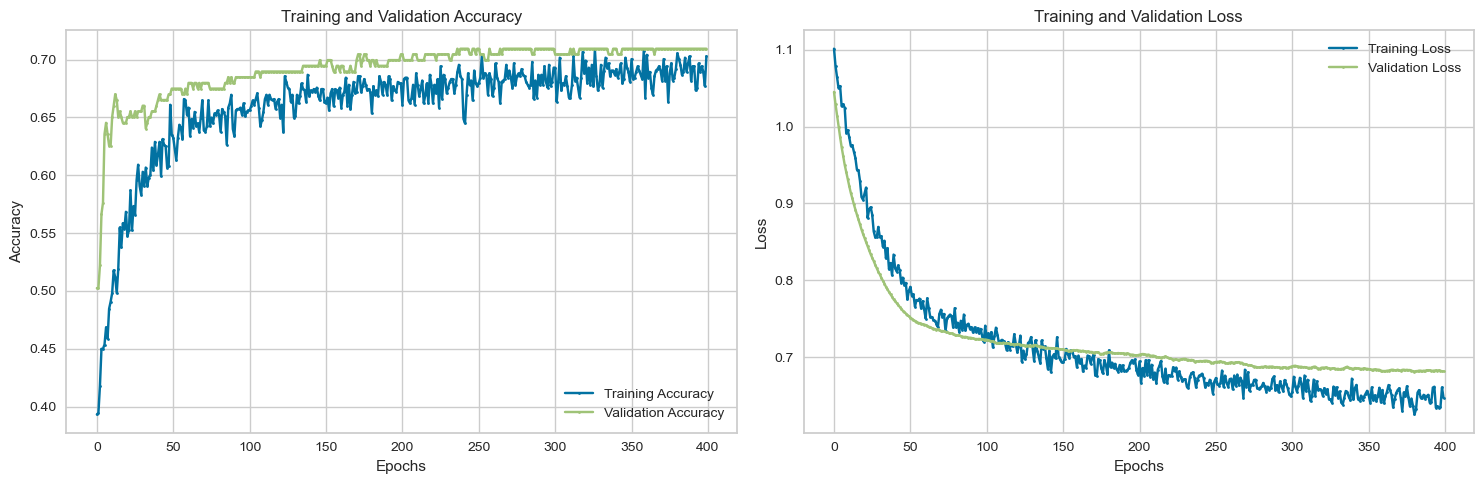

In [40]:
# Plot training & validation accuracy values
plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o', linestyle='-', markersize=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o', linestyle='-', markersize=2)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o', linestyle='-', markersize=2)
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', linestyle='-', markersize=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [41]:
# Get predictions and probabilities from the FNN model
fnn_pred_probs = fnn_model.predict(X_test_scaled)

# convert prediction to classes
fnn_pred = np.argmax(fnn_pred_probs, axis=1)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [42]:
# Evaluate the model on our unseen data(y_test)
fnn_test_accuracy = accuracy_score(y_test, fnn_pred)
fnn_classification_rep = classification_report(y_test, fnn_pred)
fnn_conf_matrix = confusion_matrix(y_test, fnn_pred)
fnn_auc = roc_auc_score(pd.get_dummies(y_test), fnn_pred_probs, multi_class='ovo', average='macro')

print(f"Test Accuracy: {fnn_test_accuracy}")
print("Classification Report:")
print(fnn_classification_rep)
print(f"AUC_Score: {fnn_auc}")
print("Confusion Matrix:")
print(fnn_conf_matrix)

Test Accuracy: 0.7093596059113301
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.93      0.78        81
           1       0.72      0.34      0.46        67
           2       0.77      0.84      0.80        55

    accuracy                           0.71       203
   macro avg       0.72      0.70      0.68       203
weighted avg       0.71      0.71      0.68       203

AUC_Score: 0.8634661818323428
Confusion Matrix:
[[75  5  1]
 [31 23 13]
 [ 5  4 46]]


### 6.3 Build an emsemble model using predictions from FNN and XGBoost

In [43]:
# Convert y_test to pandas Series
#y_test_series = pd.Series(y_test)

In [44]:
# Make a dataframe of FNN predictions
fnn_predictions = pd.DataFrame(fnn_pred_probs, columns=['Score_0', 'Score_1', 'Score_2'])
fnn_predictions['Label'] = fnn_predictions.idxmax(axis=1).str.replace('Score_', '').astype(int)
#fnn_predictions['RiskLevel_encode'] = y_test_series.reset_index(drop=True)

print(fnn_predictions)

          Score_0   Score_1   Score_2  Label
0    2.984550e-02  0.946844  0.023310      1
1    5.907752e-01  0.406508  0.002717      0
2    3.215076e-02  0.265972  0.701877      2
3    1.725243e-11  0.001382  0.998618      2
4    5.835076e-02  0.935432  0.006217      1
..            ...       ...       ...    ...
198  6.160765e-01  0.380366  0.003558      0
199  7.072811e-01  0.291720  0.000999      0
200  3.156483e-01  0.555977  0.128375      1
201  8.727876e-02  0.374136  0.538585      2
202  1.552247e-01  0.785123  0.059652      1

[203 rows x 4 columns]


In [45]:
# Make a dataframe of XGB predictions
xgb_pred_df = pd.DataFrame(xgb_test_pred, columns=['Label'])

# Make a dataframe of probabilities
xgb_prob_df = pd.DataFrame(xgb_test_prob, columns=['Score_0', 'Score_1', 'Score_2'])

# Concatenate the predictions and probabilities DataFrames
xgb_predictions = pd.concat([xgb_pred_df, xgb_prob_df], axis=1)

# Add the true labels to the combined DataFrame
#xgb_predictions['RiskLevel_encode'] = y_test_series.reset_index(drop=True)

print(xgb_predictions.head())

   Label   Score_0   Score_1   Score_2
0      1  0.001550  0.995219  0.003230
1      0  0.981050  0.016361  0.002589
2      2  0.004529  0.179228  0.816244
3      2  0.000471  0.000951  0.998578
4      1  0.001409  0.998256  0.000335


In [46]:
# Ensure both predictions DataFrames have the same index
xgb_predictions = xgb_predictions.reset_index(drop=True)
fnn_predictions = fnn_predictions.reset_index(drop=True)

In [47]:
# Extract necessary columns for probabilities
xgb_probs = xgb_predictions[['Score_0', 'Score_1', 'Score_2']]
fnn_probs = fnn_predictions[['Score_0', 'Score_1', 'Score_2']]

In [49]:
# Average the probabilities from both models
ensemble_probs = (xgb_probs.values + fnn_probs.values) / 2

# Check that the combined probabilities sum to 1
assert np.allclose(ensemble_probs.sum(axis=1), 1), "Probabilities should sum to 1 for each sample"

# Determine the final predicted class based on the maximum combined probability
ensemble_pred = np.argmax(ensemble_probs, axis=1)

# Assuming y_true contains the true labels
#y_true = y_test  # Replace with your true labels


In [50]:
# Evaluate the model on our unseen data(y_test)
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
ensemble_classification_rep = classification_report(y_test, ensemble_pred)
ensemble_conf_matrix = confusion_matrix(y_test, ensemble_pred)
ensemble_auc = roc_auc_score(pd.get_dummies(y_test), ensemble_probs, multi_class='ovo', average='macro')

print(f"Test Accuracy: {ensemble_accuracy}")
print("Classification Report:")
print(ensemble_classification_rep)
print(f"AUC_Score: {ensemble_auc}")
print("Confusion Matrix:")
print(ensemble_conf_matrix)

Test Accuracy: 0.8817733990147784
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        81
           1       0.88      0.87      0.87        67
           2       0.89      0.87      0.88        55

    accuracy                           0.88       203
   macro avg       0.88      0.88      0.88       203
weighted avg       0.88      0.88      0.88       203

AUC_Score: 0.9682944237690796
Confusion Matrix:
[[73  6  2]
 [ 5 58  4]
 [ 5  2 48]]
